In [1]:
import random
import numpy as np

import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")

import keras
print(f"Keras Version: {keras.__version__}")


# gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# List physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth and limit memory usage
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])  # Memory limit in MB
    except RuntimeError as e:
        print(e)

# Now you can create your session or model
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto())

2024-06-09 01:30:05.306426: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 01:30:05.306475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 01:30:05.307955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version: 2.15.0
Keras Version: 3.3.3


In [2]:

seed = random.randint(0, 1000)

# Set random seeds
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"SEED: {seed}")

SEED: 361


In [3]:
# Management Modules
import os
import random
from glob import glob
from tqdm import tqdm
from collections import Counter

# Data loading and transformation
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Pre-trained models
from tensorflow.keras.applications import ResNet50V2, ResNet152V2, MobileNetV2, Xception

# Model Layers
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Model Checkpoints
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Model Hyertunig and Metrices
from keras_tuner.tuners import Hyperband
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Specify the root file path
directory_path = "/kaggle/input/salmonscan/SalmonScan/Raw/"
N_CLASSES = 2
IMAGE_SIZE = (224,224,3)
epochs= 50

In [5]:
def create_callbacks(name, patience):
    return [
        EarlyStopping(patience=patience, restore_best_weights=True, verbose=1),
        ModelCheckpoint(name + ".h5", save_best_only=True, monitor="val_loss")
    ]

In [6]:
# Collect the class names
class_names = os.listdir(directory_path)

# Show the information
print(f"Number of Classes: {N_CLASSES}")
print("Class Names:")
for index, name in enumerate(class_names):
    print(f"{index + 1:2}. {name}")

Number of Classes: 2
Class Names:
 1. InfectedFish
 2. FreshFish


In [7]:
# Compute the sample size for each class
class_sample_size = [len(os.listdir(directory_path + class_name))
                     for class_name in class_names]

# Calculate the total number of images
total_n_images = sum(class_sample_size)

# Calculate the percentage of sample size for each class
percentage_sample_size = [value / total_n_images *
                          100 for value in class_sample_size]

# Sort the class sample sizes in descending order
sorted_class_sample_size = sorted(class_sample_size, reverse=True)

# Display the class names, data size, percentage, and rank
class_distribution_df = pd.DataFrame({
    "Class Names": class_names,
    "Data Size": class_sample_size,
    "Percentage(%)": percentage_sample_size
})

# Calculate the rank of each class based on data size
class_distribution_df["Rank"] = class_distribution_df["Data Size"].rank(
    method="dense", ascending=False)

# Show the data
class_distribution_df

,Class Names,Data Size,Percentage(%),Rank
0,InfectedFish,91,79.824561,1.0
1,FreshFish,23,20.175439,2.0


In [8]:
# Visualize the class distribution
fig = px.bar(
    data_frame=class_distribution_df,
    x="Class Names",
    y="Data Size",
    text="Data Size",
    hover_data=["Percentage(%)", "Rank"],
    title="Class Distribution of Insects in the Dataset",
    color_discrete_sequence=px.colors.qualitative.D3,
    height=600,
)

# Set axis labels and adjust layout
fig.update_layout(
    xaxis_title="Class Names",
    yaxis_title="Data Size",
    yaxis_tickformat="d",
    yaxis=dict(showgrid=False),
    showlegend=False,
)

# Show the plot
fig.show()

In [9]:


# Computer class weights.
class_weights = [total_n_images / (N_CLASSES * class_samples)
                 for class_samples in class_sample_size]

# Add this data into the data frame
class_distribution_df["Class Weights"] = class_weights

# Show the updated data
class_distribution_df



,Class Names,Data Size,Percentage(%),Rank,Class Weights
0,InfectedFish,91,79.824561,1.0,0.626374
1,FreshFish,23,20.175439,2.0,2.478261


In [10]:
# Initialize empty lists to collect image paths and class labels
all_image_paths = []
class_labels = []

# Collect all image paths and corresponding class labels
for class_name in class_names:
    paths = glob(directory_path + f"{class_name}/*")
    all_image_paths.extend(paths)
    class_labels.extend([class_name] * len(paths))

# Perform stratified data split
train_images, valid_test_images = train_test_split(
    all_image_paths, train_size=0.8, test_size=0.2, stratify=class_labels)
valid_images, test_images = train_test_split(
    valid_test_images, train_size=0.9, test_size=0.1)

In [11]:
# Extract class labels for trained images
trained_class_labels = [os.path.split(path)[0].split("/")[-1] for path in train_images]

# Compute class distribution
class_distribution = dict(Counter(trained_class_labels))

# Compute class weights
total_trained_images = len(train_images)
train_class_weights = {class_label: total_trained_images /
                       (N_CLASSES * class_samples) for class_label, class_samples in class_distribution.items()}

# Display the class weights of the training images
print(f"  Class Name {' '*27} Train Class Weight {' '} Original Class Weights")
for index, (name, weight) in enumerate(train_class_weights.items()):
    original_weight = class_distribution_df[class_distribution_df["Class Names"]
                                            == name]["Class Weights"].values[0]
    print(f"{index+1:2}. {name:40} {weight:.3f} {original_weight:25.3f}")

  Class Name                             Train Class Weight   Original Class Weights
 1. InfectedFish                             0.623                     0.626
 2. FreshFish                                2.528                     2.478


In [12]:
class FarmInsects:
    """
    A class for loading and processing farm insect images dataset.
    """

    def __init__(self, class_names: list, n_classes: int, image_size: tuple = (256, 256, 3)):
        """
        Initialize FarmInsects class.

        Args:
            class_names (list): List of class names.
            n_classes (int): Number of classes.
            image_size (tuple): Size of the images (height, width, channels).
        """
        self.image_size = image_size
        self.class_names = class_names
        self.n_classes = n_classes

    def load_image(self, image_path: str) -> tf.Tensor:
        """
        Load and preprocess an image.

        Args:
            image_path (str): Path to the image file.

        Returns:
            tf.Tensor: Preprocessed image tensor.
        """
        image_file = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_file, channels=3)
        image = tf.image.resize(image, self.image_size[:2])
        image = image / 255.

        return image

    def extract_label(self, image_path: str, names: bool = False) -> int or str:
        """
        Extract the label from the image path.

        Args:
            image_path (str): Path to the image file.
            names (bool): Whether to return class names or numerical labels.

        Returns:
            int or str: Numerical label or class name.
        """
        name = os.path.split(image_path)[0].split("/")[-1]
        if names:
            return name
        else:
            label = self.class_names.index(name)
            return label

    def load_data(self, image_paths: list, desc: str = "Loading", one_hot: bool = True, names: bool = False) -> tuple:
        """
        Load the images and labels from the given image paths.

        Args:
            image_paths (list): List of image paths.
            desc (str): Description for tqdm progress bar.
            one_hot (bool): Whether to use one-hot encoding for labels.
            names (bool): Whether to return class names instead of numerical labels.

        Returns:
            tuple: Tuple containing the loaded images and labels.
        """
        self.images = np.empty((len(image_paths),) + self.image_size, dtype=np.float32)

        if names:
            self.labels = []
        else:
            self.labels = np.empty((len(image_paths),), dtype=np.int32)

        for index, path in tqdm(enumerate(image_paths), desc=desc):
            image = self.load_image(image_path=path)
            label = self.extract_label(image_path=path, names=names)
            self.images[index] = image

            if names:
                self.labels.append(label)
            else:
                self.labels[index] = label

        if one_hot and not names:
            one_hot_labels = tf.one_hot(self.labels, depth=self.n_classes)
            return self.images, one_hot_labels
        else:
            return self.images, self.labels

    def show_random_images(self, grid: tuple, image_paths: list, figsize: tuple = (25, 20)):
        """
        Display random images from the given image paths.

        Args:
            grid (tuple): Tuple specifying the grid size (number of rows, number of columns).
            image_paths (list): List of image paths.
            figsize (tuple): Figure size for displaying the images.
        """
        n_rows, n_cols = grid
        n_images = n_rows * n_cols

        image_indexes = np.random.randint(0, len(image_paths), size=n_images)
        image_paths = np.take(image_paths, image_indexes)

        images, labels = self.load_data(image_paths=image_paths, one_hot=False, names=True)

        plt.figure(figsize=figsize)

        for plot_index in range(1, n_images + 1):
            plt.subplot(n_rows, n_cols, plot_index)
            plt.imshow(images[plot_index - 1])
            plt.title(label=labels[plot_index - 1])
            plt.axis('off')

        plt.show()

In [13]:
# Initialize dataset
farm_data = FarmInsects(class_names=class_names, n_classes=N_CLASSES, image_size=IMAGE_SIZE)

# Load Training Data
trainXs, trainYs = farm_data.load_data(image_paths=train_images, desc="Training Data")

# Load testing Data
testXs, testYs = farm_data.load_data(image_paths=test_images, desc="Testing Data")

# Load validation Data
validXs, validYs = farm_data.load_data(image_paths=valid_images, desc="Validation Data")

Training Data: 91it [00:02, 39.26it/s]
Testing Data: 3it [00:00, 44.58it/s]
Validation Data: 20it [00:00, 46.59it/s]


Loading: 25it [00:00, 63.24it/s]


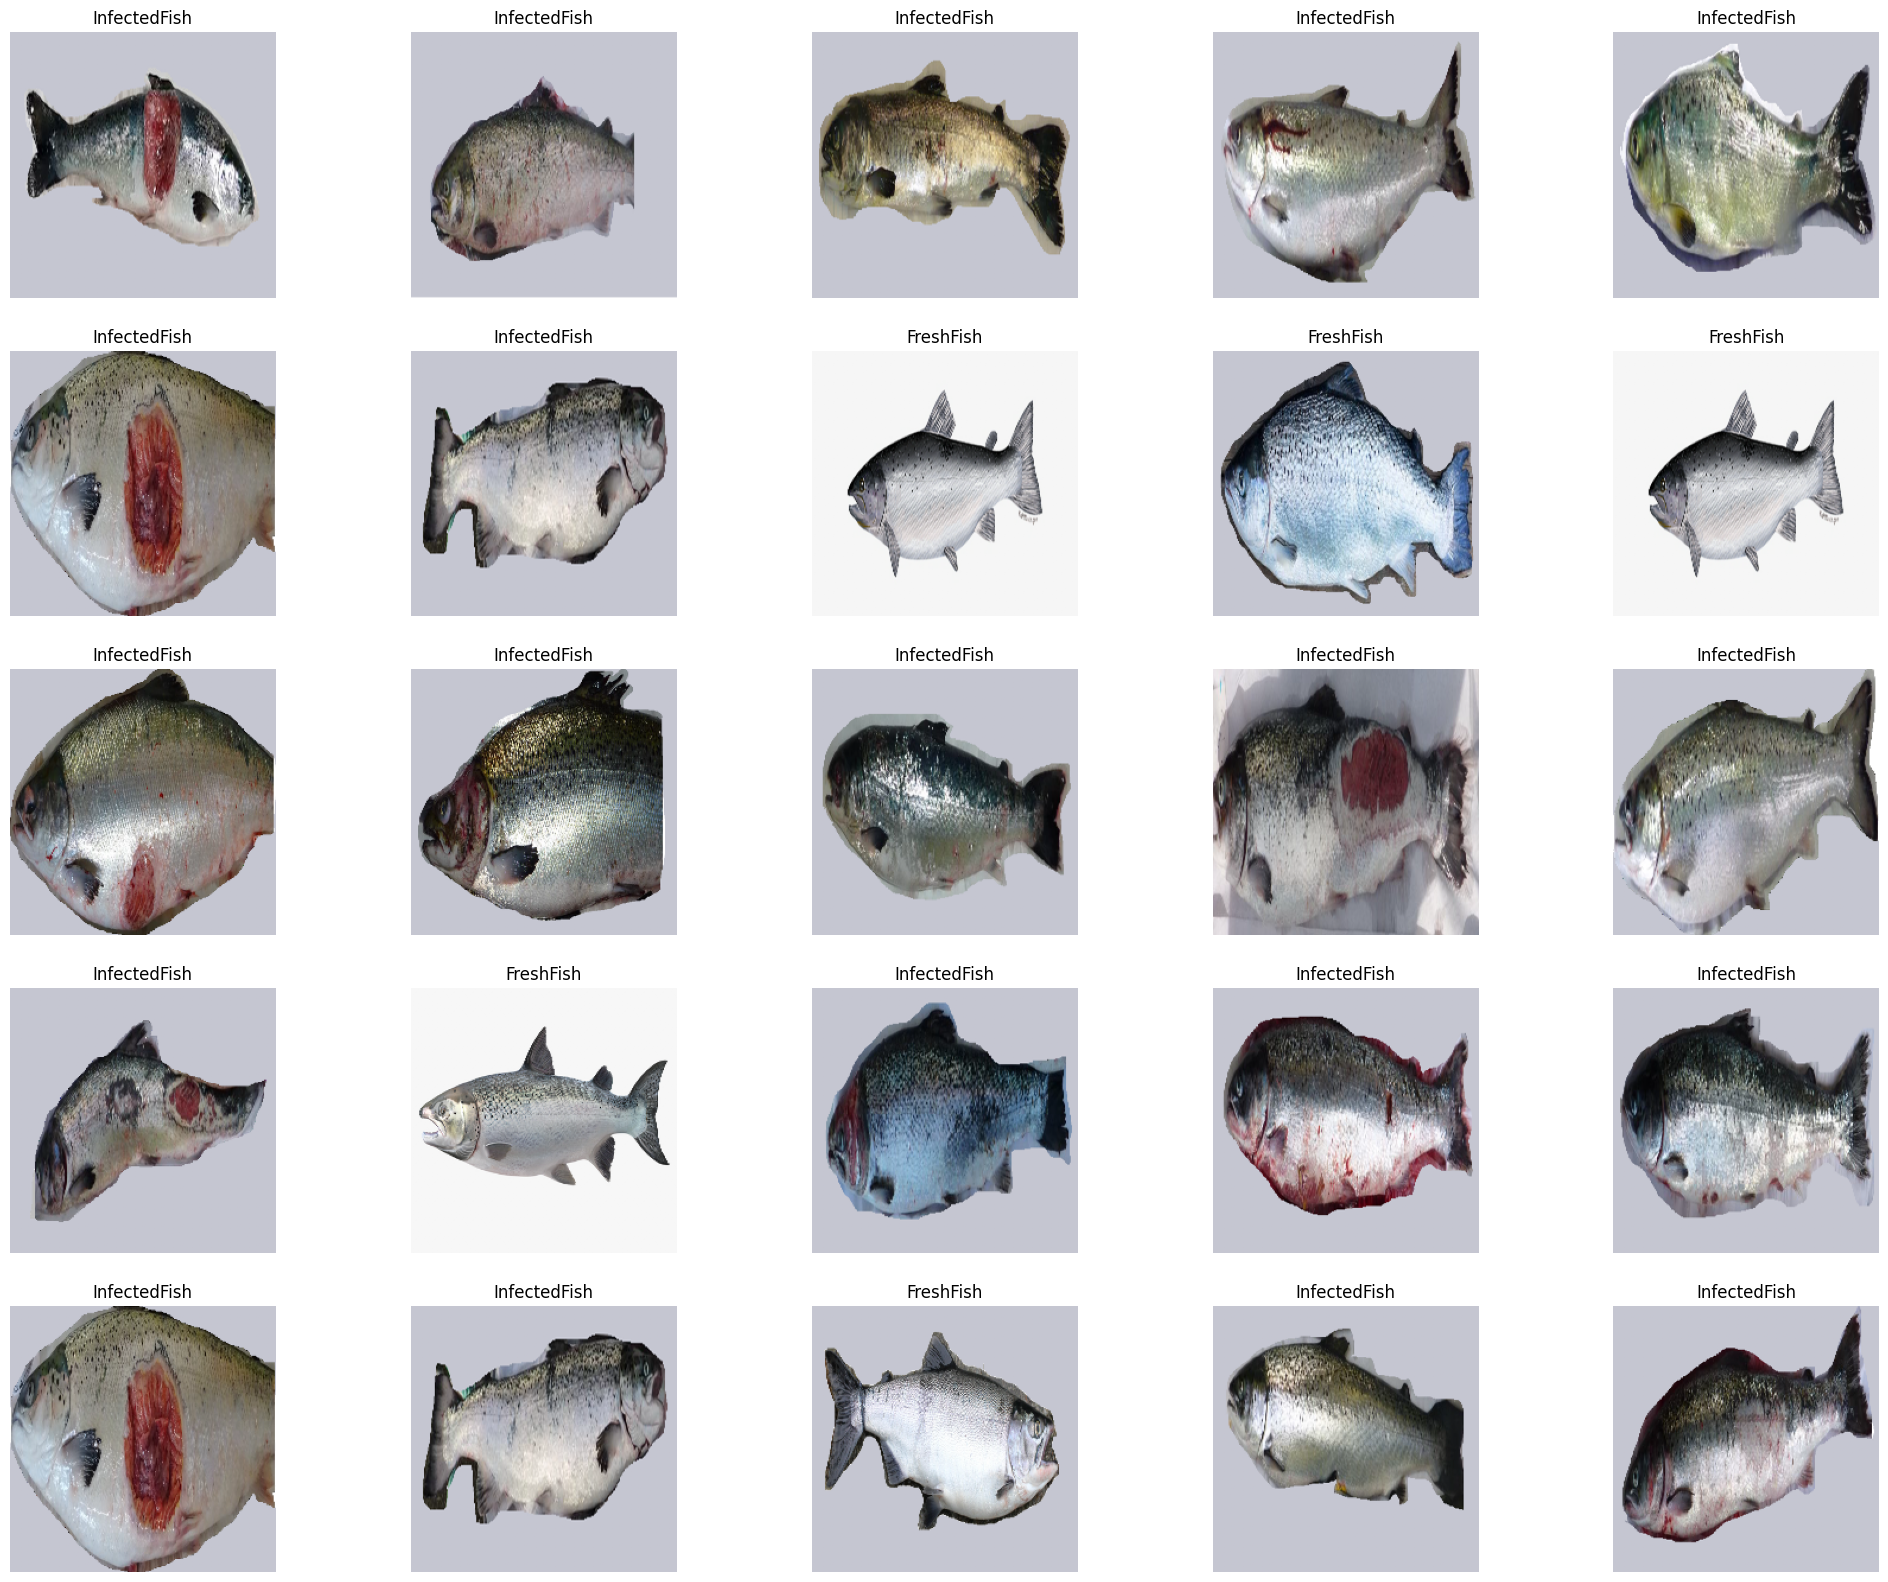

In [14]:
# Using in-built method
farm_data.show_random_images(image_paths=train_images, grid=(5,5))

In [15]:
# Converting the class weights from a list to dictionary
class_weights_dict = dict(zip(range(N_CLASSES), class_distribution_df["Class Weights"]))
class_weights_dict

{0: 0.6263736263736264, 1: 2.4782608695652173}

In [16]:
class Model:
    models = [
        ResNet50V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        ResNet152V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        MobileNetV2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        Xception(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
    ]

    model_names = [
        "ResNet50V2",
        "ResNet152V2",
        "MobileNetV2",
        "Xception"
    ]

    def __init__(self, model_name: str):
        """
        Initialize the Model class with the specified pre-trained model.
        
        Args:
            model_name (str): Name of the pre-trained model to be used.
        """
        self.model_name = model_name
        self.index = self.model_names.index(model_name)
        self.backbone = self.models[self.index]

    def train(self, trainXs, trainYs, validation_data, epochs=epochs, batch_size=32, verbose=1):
        """
        Train the model using the specified training and validation data.
        
        Args:
            trainXs (numpy.ndarray): Training images.
            trainYs (numpy.ndarray): Training labels.
            validation_data: Validation data as a tuple (valXs, valYs).
            epochs (int): Number of epochs to train the model.
            batch_size (int): Batch size for training.
            verbose (int): Verbosity level for training logs (0, 1, or 2).
        """
        self.backbone.trainable = False

        self.model = Sequential([
            self.backbone,
            GlobalAveragePooling2D(),
            Dropout(0.4),
            Dense(256, activation='relu'),            
            Dense(128, activation='relu'),
            Dense(N_CLASSES, activation='softmax')
        ])

        self.model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=['accuracy']
        )

        self.history = self.model.fit(
            trainXs, trainYs,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights_dict,
            steps_per_epoch=len(trainXs)//batch_size,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=verbose
        )

    def visualize_training(self):
        """
        Visualize the training history.
        """
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"{self.model_name} Training Curve")

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label="Loss", color="g")
        plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (crossentropy)")
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
        plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.legend()

        plt.show()
    
    def evaluate(self, testXs, testYs, verbose=1, visualize=False):
        
        test_loss, test_acc = self.model.evaluate(testXs, testYs, verbose=verbose)
        
        if visualize:
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{self.model_name} Performance Check")
            plt.subplot(1, 2, 1)
            plt.plot(self.history.history['loss'], label="Loss", color="g")
            plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
            plt.axhline(test_loss, color='black', alpha=0.8, linestyle="--", label="Test Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss (crossentropy)")
            plt.grid()
            plt.ylim([0, 1.5])
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
            plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
            plt.axhline(test_acc, color='black', alpha=0.8, linestyle="--", label="Test Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0.4, 1.0])
            plt.grid()
            plt.legend()

            plt.show()
        else:
            return test_loss, test_acc

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3828 - loss: 1.3837

I0000 00:00:1717896643.518291    1722 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717896643.562129    1722 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717896654.169857    1724 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 11s/step - accuracy: 0.4271 - loss: 1.5035 - val_accuracy: 0.8000 - val_loss: 0.6047
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 12s 13s/step - accuracy: 0.8148 - loss: 1.2726

W0000 00:00:1717896667.388125    1723 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - accuracy: 0.8148 - loss: 1.2726 - val_accuracy: 0.9000 - val_loss: 0.3136
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8750 - loss: 0.5478 - val_accuracy: 0.7000 - val_loss: 0.5528
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5926 - loss: 0.4957 - val_accuracy: 0.7000 - val_loss: 0.5968
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.6146 - loss: 0.5001 - val_accuracy: 0.8500 - val_loss: 0.2978
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8148 - loss: 0.2624 - val_accuracy: 0.9000 - val_loss: 0.2302
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9688 - loss: 0.1906 - val_accuracy: 0.9500 - val_loss: 0.2309
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9630 - loss: 0.1626 - val_accuracy: 0.9500 - val_loss: 0.2509
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9271 - loss: 0.2044 - val_accuracy: 0.9500 - val_loss: 0.2549
Epoc

W0000 00:00:1717896678.021869    1723 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


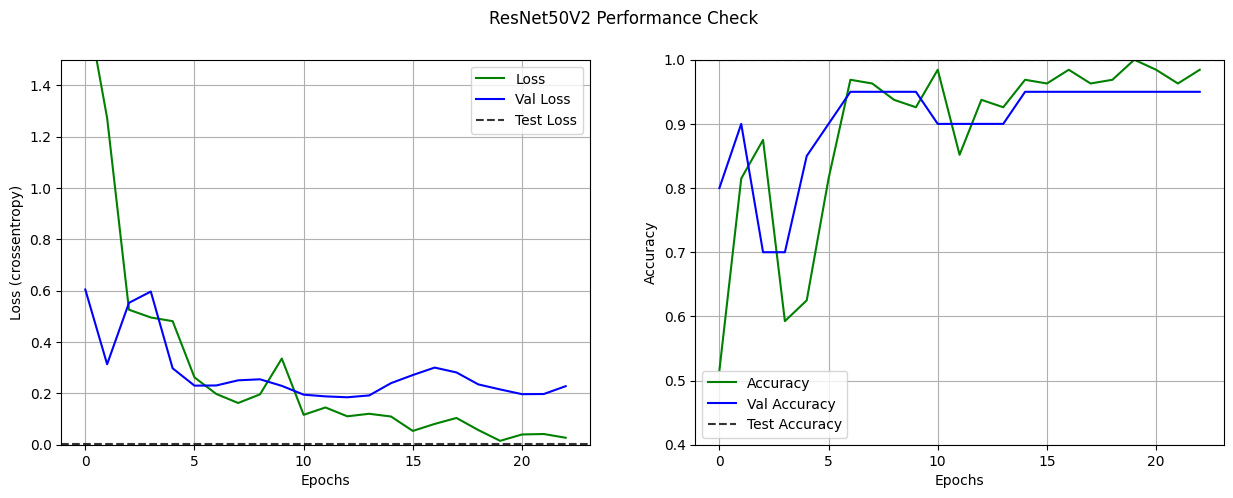

In [17]:
# Initialize the ResNet50V2 model
resnet50_model = Model(model_name="ResNet50V2")

# Train the model
resnet50_model.train( 
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=1,
)

# Evaluate model performance on testing data.
resnet50_model.evaluate(testXs, testYs, visualize=True, verbose=1)

Epoch 1/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.4688 - loss: 0.7606

W0000 00:00:1717896704.880440    1722 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5469 - loss: 0.8655

W0000 00:00:1717896715.079881    1722 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 11s/step - accuracy: 0.5729 - loss: 0.9004 - val_accuracy: 0.8000 - val_loss: 0.5431
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step - accuracy: 0.8889 - loss: 0.2740

W0000 00:00:1717896724.791491    1723 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.8889 - loss: 0.2740 - val_accuracy: 0.6000 - val_loss: 1.0129
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - accuracy: 0.6667 - loss: 0.5158 - val_accuracy: 0.9000 - val_loss: 0.3353
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step - accuracy: 0.8889 - loss: 0.2010 - val_accuracy: 0.9500 - val_loss: 0.2936
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - accuracy: 0.9271 - loss: 0.3270 - val_accuracy: 0.9500 - val_loss: 0.2145
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step - accuracy: 0.8889 - loss: 0.2505 - val_accuracy: 0.9500 - val_loss: 0.1586
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 0.9375 - loss: 0.1216 - val_accuracy: 0.9500 - val_loss: 0.1998
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9259 - loss: 0.1553 - val_accuracy: 0.9500 - val_loss: 0.1865
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - accuracy: 0.9062 - loss: 0.0882 - val_accuracy: 1.0000 - val_loss: 0.0932
Epo

W0000 00:00:1717896742.490230    1723 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


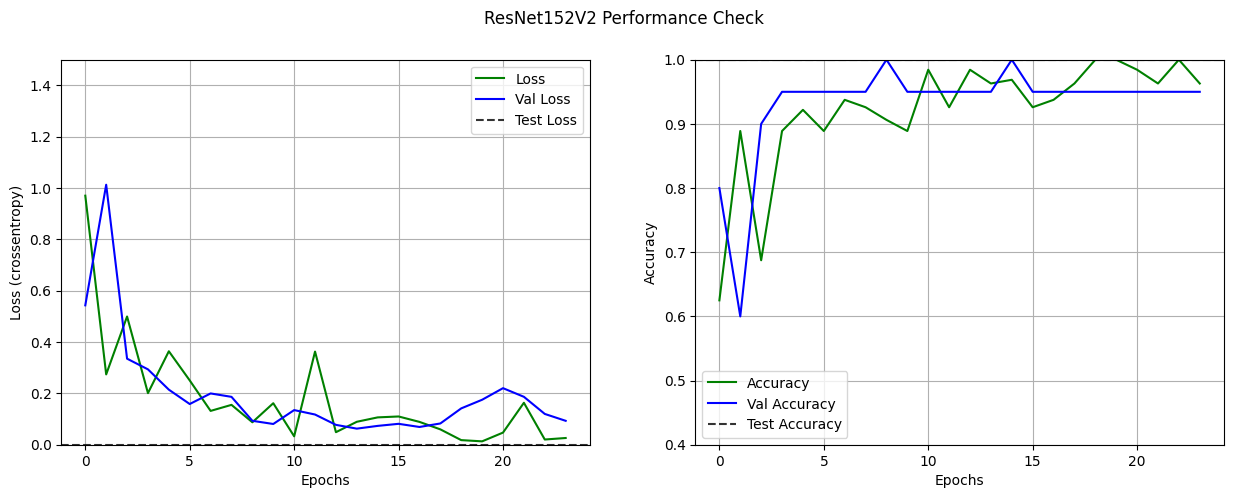

In [18]:
# Initialize the ResNet152V2 model
resnet152_model = Model(model_name="ResNet152V2")

# Train the model
resnet152_model.train( 
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=1,
)

# Evaluate model performance on testing data.
resnet152_model.evaluate(testXs, testYs, visualize=True, verbose=1)

Epoch 1/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 13s 14s/step - accuracy: 0.4375 - loss: 0.7804

W0000 00:00:1717896756.738149    1723 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.5625 - loss: 0.7285 - val_accuracy: 0.8500 - val_loss: 0.4196
Epoch 2/50


W0000 00:00:1717896763.709348    1722 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.8519 - loss: 0.2915 - val_accuracy: 0.7000 - val_loss: 0.4652
Epoch 3/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7812 - loss: 0.3355

W0000 00:00:1717896772.853906    1722 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8229 - loss: 0.3197 - val_accuracy: 1.0000 - val_loss: 0.1510
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9259 - loss: 0.1147 - val_accuracy: 1.0000 - val_loss: 0.0886
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9479 - loss: 0.1906 - val_accuracy: 1.0000 - val_loss: 0.0761
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9630 - loss: 0.1071 - val_accuracy: 1.0000 - val_loss: 0.0996
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9375 - loss: 0.0751 - val_accuracy: 0.9500 - val_loss: 0.1005
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9630 - loss: 0.0486 - val_accuracy: 1.0000 - val_loss: 0.0699
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9688 - loss: 0.0414 - val_accuracy: 1.0000 - val_loss: 0.0202
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0129
Epoc

W0000 00:00:1717896781.399717    1725 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


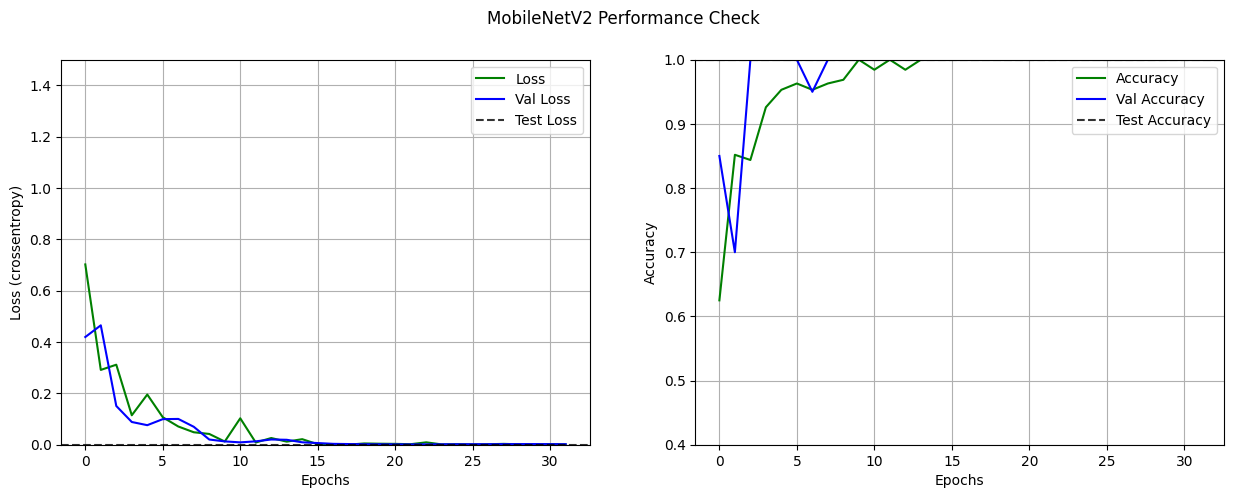

In [19]:
# Initialize the MobileNetV2 model
mobilenetv2_model = Model(model_name="MobileNetV2")

# Train the model
mobilenetv2_model.train( 
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=1,
)

# Evaluate model performance on testing data.
mobilenetv2_model.evaluate(testXs, testYs, visualize=True, verbose=1)

Epoch 1/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.6562 - loss: 0.7264

W0000 00:00:1717896804.049366    1725 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7031 - loss: 0.7021

W0000 00:00:1717896816.005198    1722 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 12s/step - accuracy: 0.7188 - loss: 0.6940 - val_accuracy: 0.7500 - val_loss: 0.4022
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.8889 - loss: 0.4205

W0000 00:00:1717896832.583768    1723 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - accuracy: 0.8889 - loss: 0.4205 - val_accuracy: 0.7500 - val_loss: 0.3417
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9167 - loss: 0.2622 - val_accuracy: 0.8000 - val_loss: 0.2965
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8889 - loss: 0.3111 - val_accuracy: 0.8500 - val_loss: 0.2787
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9167 - loss: 0.1588 - val_accuracy: 0.8000 - val_loss: 0.2718
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8519 - loss: 0.2156 - val_accuracy: 0.9000 - val_loss: 0.2206
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9479 - loss: 0.1178 - val_accuracy: 0.9000 - val_loss: 0.1698
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9630 - loss: 0.0749 - val_accuracy: 0.9000 - val_loss: 0.1452
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9688 - loss: 0.0782 - val_accuracy: 0.9000 - val_loss: 0.1121
Ep

W0000 00:00:1717896844.352636    1725 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


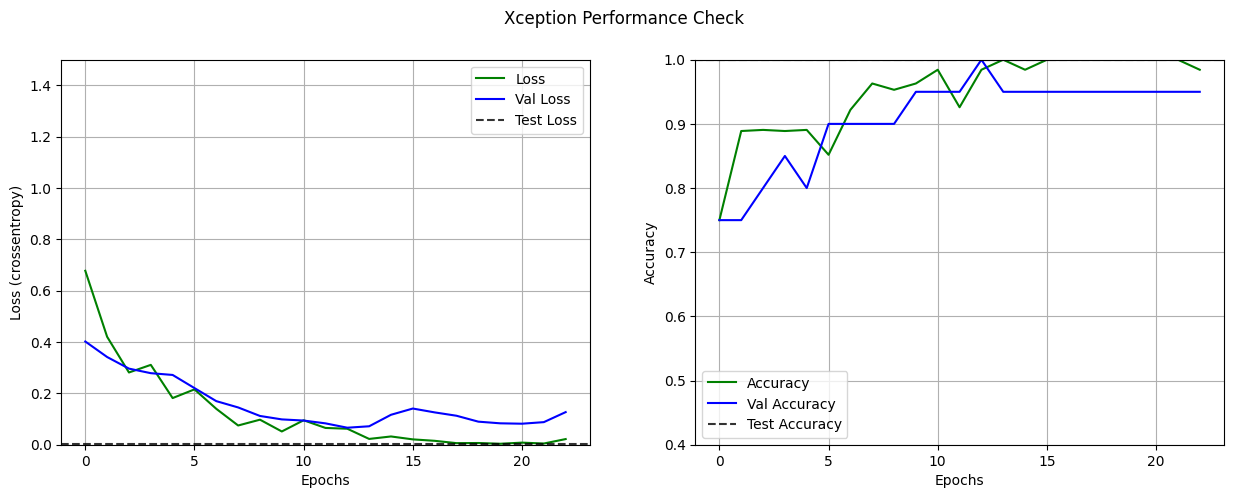

In [20]:
# Initialize the Xception model
xception_model = Model(model_name="Xception")

# Train the model
xception_model.train( 
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=1,
)

# Evaluate model performance on testing data.
xception_model.evaluate(testXs, testYs, visualize=True, verbose=1)

W0000 00:00:1717896846.935748    1725 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717896848.843665    1724 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


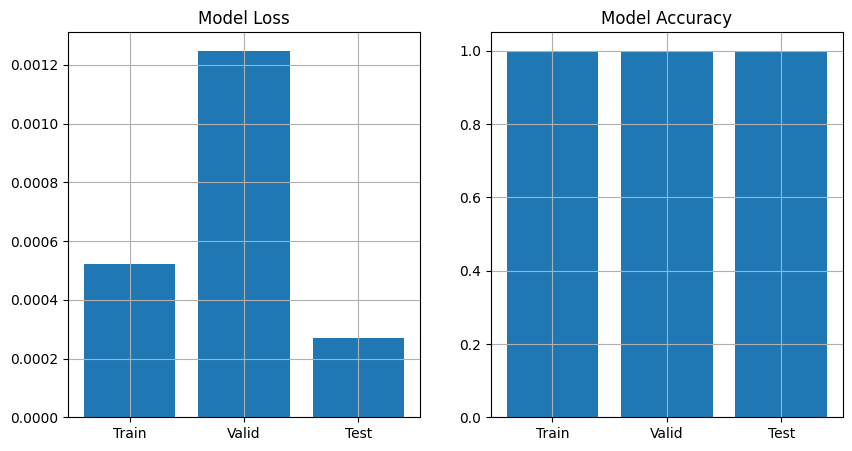

In [21]:
# Model evaluation
train_loss, train_acc = mobilenetv2_model.evaluate(trainXs, trainYs, verbose=0)
valid_loss, valid_acc =mobilenetv2_model.evaluate(validXs, validYs, verbose=0)
test_loss, test_acc = mobilenetv2_model.evaluate(testXs, testYs, verbose=0)

# Visualizing Model Performance
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Model Loss")
plt.bar(["Train", "Valid", "Test"], [train_loss, valid_loss, test_loss])
plt.grid()

plt.subplot(1,2,2)
plt.title("Model Accuracy")
plt.bar(["Train", "Valid", "Test"], [train_acc, valid_acc, test_acc])
plt.grid()

plt.show()